# 1. Introduction

A/B testing is a fundamental methodology in data science and digital marketing allowing organizations to make data-driven decisions regarding changes in their products or services. In this project, we aim to evaluate the impact of a new website design on user engagement. User engagement is a critical metric for website performance, often measured by the amount of time users spend on the site. By comparing user behavior between the current website design (control group) and the new design (treatment group), we can determine if the redesign leads to increased engagement.

**Project Objectives**:

**Determine the Effectiveness of the New Design**: Assess whether the new website design improves user engagement compared to the old design.

Dataset: https://www.kaggle.com/datasets/zhangluyuan/ab-testing/data


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

In [5]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0.0
1,804228,01:45.2,control,old_page,0.0
2,661590,55:06.2,treatment,new_page,0.0
3,853541,28:03.1,treatment,new_page,0.0
4,864975,52:26.2,control,old_page,1.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58253 entries, 0 to 58252
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       58253 non-null  int64  
 1   timestamp     58253 non-null  object 
 2   group         58252 non-null  object 
 3   landing_page  58252 non-null  object 
 4   converted     58252 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.2+ MB


The dataset contains 5 columns , 294480 records:

- user_id: unique id of the user who came to the website
- timestamp: timestamp that the user came to the page
- group: whether the user in treatment group or control group
- landing_page: whether the user saw the old page or new page
- converted: whether the user converted to a paid user. 1 means converted, 0 means not converted.

# Data Cleaning


**Remove the mismatched data:**

*   Remove the records that control group visit new_page
*   Remove the records that treatment group visit old_page



In [7]:
df =df.drop(df[(df.landing_page == "new_page") & (df.group == "control")].index)
df =df.drop(df[(df.landing_page == "old_page") & (df.group == "treatment")].index)

In [8]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,28727
treatment,28727,0


In [9]:
df.shape

(57455, 5)

**Remove duplicate user_id**

In [10]:
df=df.drop_duplicates(subset=['user_id'])

## Visualization

A simple bar chart showing the total converted versus no-converted in each group can provide a clear visual comparison of user engagement.

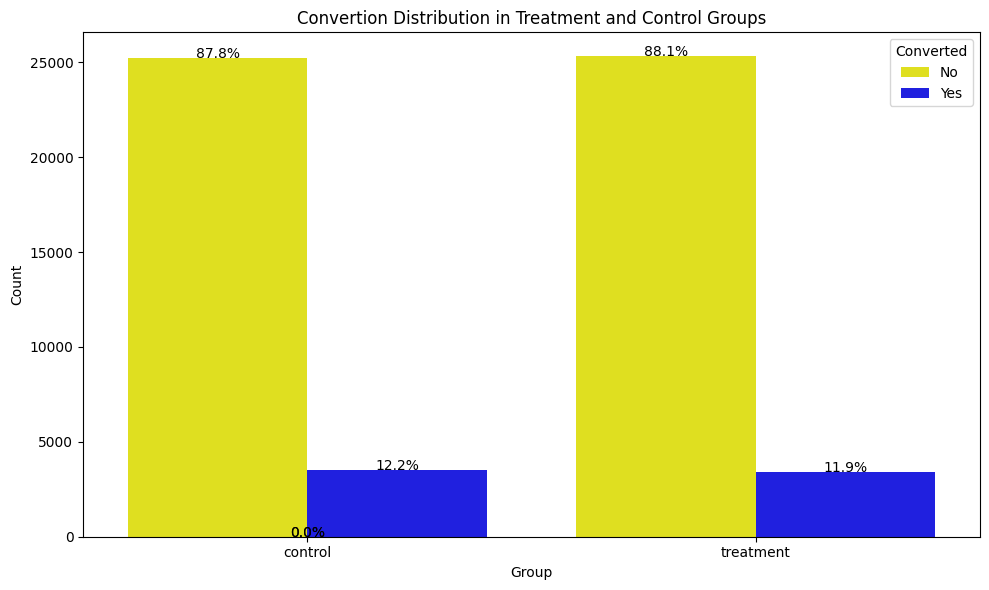

In [24]:
# Custom palette for yellow and blue
palette = {0: 'yellow', 1: 'blue'}  # Assuming 0 is for no-converted, 1 for converted

# Plotting the click distribution for each group with the custom colors
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='group', hue='converted', data=df, palette=palette)
plt.title('Convertion Distribution in Treatment and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Converted', labels=['No', 'Yes'])

# Calculate the percentages and annotate the bars
group_counts = df.groupby(['group']).size()
group_converted_counts = df.groupby(['group', 'converted']).size().reset_index(name='count')

for p in ax.patches:
    height = p.get_height()
    # Find the group and click type for the current bar
    con_treat = 'treatment' if p.get_x() < 0.5 else 'control'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[con_treat]
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha="center", color='black', fontsize=10)

plt.tight_layout()
plt.show()

# AB Testing

## Hypotheses Statement


To conduct a structured and objective analysis, we define the following hypotheses:

**Null Hypothesis (H0)**: The new website design does not impact user engagement, meaning there is no significant difference in the average time spent on the site between the control group and the treatment group.

**Alternative Hypothesis (H1)**: The new website design increases user engagement, resulting in a significant difference in the average time spent on the site between the control group and the treatment group.

## Power Analysis



### Parameters of the Model from Power Analysis

In [12]:
alpha = 0.05 # 5%
print("Alpha: significance level is:", alpha )

delta = 0.02 # 10%
print("Delta: minimum detectable effect is:", delta )

Alpha: significance level is: 0.05
Delta: minimum detectable effect is: 0.02


### Calculating total number of converted per group by summing converted

In [13]:
N_con = df[df["group"] == "control"].count()[0]
N_exp = df[df["group"] == "treatment"].count()[0]

# calculating the total number of clicks per group by summing 1's
X_con = df.groupby("group")["converted"].sum().loc["control"]
X_exp = df.groupby("group")["converted"].sum().loc["treatment"]

# printing this for visibility
print(df.groupby("group")["converted"].sum())
print("Number of user in Control: ", N_con)
print("Number of users in Treatment: ", N_exp)
print("Number of Converted in Control: ", X_con)
print("Number of Converted in Treatment: ", X_exp)

group
control      3498.0
treatment    3410.0
Name: converted, dtype: float64
Number of user in Control:  28727
Number of users in Treatment:  28726
Number of Converted in Control:  3498.0
Number of Converted in Treatment:  3410.0


### Calculating Pooled Estimates for Converted per Group

In [14]:
# computing the estimate of click probability per group
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp
print("Converted Probability in Control Group:", p_con_hat)
print("Converted Probability in Treatment Group:", p_exp_hat)

# computing the estimate of pooled clicked probability
p_pooled_hat = (X_con+X_exp)/(N_con + N_exp)
print("Pooled Converted Probability:", p_pooled_hat)

Converted Probability in Control Group: 0.12176697880043165
Converted Probability in Treatment Group: 0.11870779085149342
Pooled Converted Probability: 0.12023741144935861


### Calculating Pooled Variance

In [15]:
# computing the estimate of pooled variance
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print("p^_pooled is: ", p_pooled_hat)
print("pooled_variance is: ", pooled_variance)

p^_pooled is:  0.12023741144935861
pooled_variance is:  7.364654682565762e-06


### Calculating Standard Error and Test Statistics

In [16]:
# computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard Error is: ", SE)

# computing the test statistics of Z-test
Test_stat = (p_con_hat - p_exp_hat)/SE
print("Test Statistics for 2-sample Z-test is:", Test_stat)

# critical value of the Z-test
Z_crit = norm.ppf(1-alpha/2)
print("Z-critical value from Standard Normal distribution: ", Z_crit)

Standard Error is:  0.0027137897270359326
Test Statistics for 2-sample Z-test is: 1.127275233766746
Z-critical value from Standard Normal distribution:  1.959963984540054


### Calculating p_values of the Z-test

- A low p-value (p ≤ 0.05 at 5% significance level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis.
- A high p-value (p > 0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis

In [17]:
#calculating p value
p_value = 2 * norm.sf(abs(Test_stat))

# function checking the statistical significance
def is_statistical_significance(p_value, alpha):
    """
    We assess whether there is statistical significance based on the p-value and alpha.

    Arguments:
    - p_value (float): The p-value resulting from a statistical test.
    - alpha (float, optional): The significance level threshold used to determine statistical significance. Defaults to 0.05.

    Returns:
    - Prints the assessment of statistical significance.
    """

    # Print the rounded p-value to 3 decimal places
    print(f"P-value of the 2-sample Z-test: {(p_value)}")

    # Determine statistical significance
    if p_value <= alpha:
        print("There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone. This suggests that the changes in the treatment group have a real effect compared to the control group.")
    else:
        print("There is no statistical significance, suggesting that the observed differences between the groups could have occurred by chance. This implies that the changes in the treatment group do not have a substantial effect compared to the control group.")



is_statistical_significance(p_value, alpha)

P-value of the 2-sample Z-test: 0.2596261301758964
There is no statistical significance, suggesting that the observed differences between the groups could have occurred by chance. This implies that the changes in the treatment group do not have a substantial effect compared to the control group.


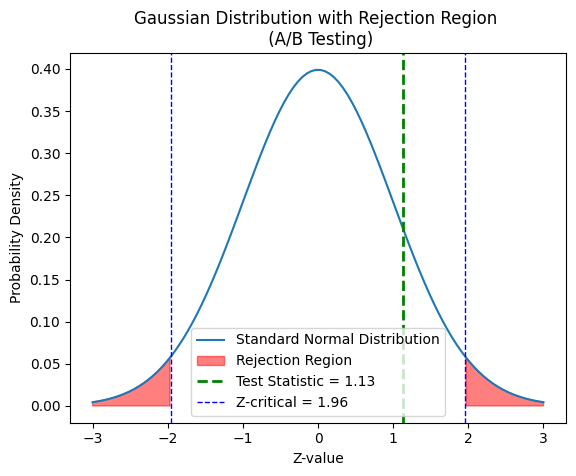

In [18]:
# Parameters for the standard normal distribution
mu = 0  # Mean
sigma = 1  # Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)


# Plotting the standard normal distribution
plt.plot(x, y, label='Standard Normal Distribution')
# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')
# Adding Test Statistic
plt.axvline(Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat:.2f}')
# Adding Z-critical values
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)

# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing)')
plt.legend()
# Show plot
plt.show()

### Calculating Confidence Interval of the test

In [19]:
# Calculate the Confidence Interval (CI) for a 2-sample Z-test
## Calculate the lower and upper bounds of the confidence interval
CI_95 = [
    round((p_exp_hat - p_con_hat) - SE*Z_crit, 3),  # Lower bound of the CI, rounded to 3 decimal places
    round((p_exp_hat - p_con_hat) + SE*Z_crit, 3)   # Upper bound of the CI, rounded to 3 decimal places
]

# Print the calculated confidence interval
print("Confidence Interval of the 2 sample Z-test is: ", CI_95)

# Here, the confidence interval provides a range of values within which the true difference between the experimental and control group proportions is likely to lie with a certain level of confidence (e.g., 95%).


Confidence Interval of the 2 sample Z-test is:  [-0.008, 0.002]


### Testing for Practical Significance in A/B Testing

In [20]:
def is_Practically_significant(delta, CI_95):
    """
    We assess here if the difference between Control and Experimental group is practically significant using the Minimum Detectable Effect (MDE) parameter from the Power Analysis.

    Arguments:
    - delta (float): The Minimum Detectable Effect (MDE) considered for practical significance.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval.

    Returns:
    - Prints whether the experiment has practical significance based on the MDE and CI.
    """

    # Extract lower bound of 95% Confidence Interval
    lower_bound_CI = CI_95[0]

    # Check if the lower bound of the CI is greater than or equal to delta
    if delta <= lower_bound_CI:
        print(f"We have practical significance! \nWith MDE of {delta}, The difference between Control and Treatment group is practically significant.")
        return True
    else:
        print("We don't have practical significance! \nThe difference between Control and Treatment group is not practically significant.")
        return False


# Call the function
significance = is_Practically_significant(delta, CI_95)
print("Lower bound of 95% confidence interval is:", CI_95[0])


We don't have practical significance! 
The difference between Control and Treatment group is not practically significant.
Lower bound of 95% confidence interval is: -0.008


# Conclusion and Decision

**Conclusion**

- There is not enough statistical evidence to claim a significant difference between the two groups (p-value > 0.05 and CI_95 includes 0).
- The observed difference is not practically significant, as it is much smaller than the expected delta (0.02).



**Decision**


Based on the statistical analysis and practical evaluation, the results of this AB testing do not show a significant difference either statistically or practically. Therefore, it is not recommended to implement the change based on these results. You may need to try a different variant or conduct additional experiments with a better design or a larger sample size to detect smaller effects.